# Homework 5

## PreProcess

**The importation library**

In [286]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from queue import Queue

**Reading documents**

Set the graph with networkx

In [118]:
graph = nx.DiGraph()
# for each link in links add edge
# the weight of edges is 1 (for all)
for line in open('wikigraph_reduced.csv', 'r').readlines()[1:]:
    nodes = line.replace('\n', '').split('\t')
    graph.add_edge(int(nodes[1]), int(nodes[2]), weight=1)

Set the category dictionary

In [121]:
categories = dict()
#for each category set the name as key and a list of nodes as article
for line in open('wiki-topcats-categories.txt', 'r').readlines():
    s = line.index(':')
    e = line.index(';')
    cat_name = line[s+1 : e].replace('_', ' ')
    cat_list = line[e+1:].split()
    categories[cat_name] = [int(c) for c in cat_list]

Compute the reverse index for categories: for each article a list of categories

In [123]:
art_cat = defaultdict(list)
for name, values in categories.items():
    for value in values:
        art_cat[value].append(name)

Set a list of pages names: for each index of a list the corrispondent page name (article name)

In [76]:
page_names = list()
for line in open('wiki-topcats-page-names.txt', 'r').readlines():
    i = line.index(' ')
    page_names.append(line[i+1:].replace('\n', ''))

compute the inverted_page_names: a dict with names as keys and index as values

In [281]:
inverted_page_names = dict()
for index, name in enumerate(page_names):
    inverted_page_names[name] = index

## RQ1

G is in the variable _graph_.

It is a directed network with all edges with weight equal to 1.

In [79]:
# Number of articles
print("The number of articles (nodes) are", len(graph.nodes))

The number of articles (nodes) are 98343


In [80]:
# number of edges/hyperlinks 
print("The number of hyperlinks (edges) are", len(graph.edges))

The number of hyperlinks (edges) are 483094


In [160]:
# average number of degree: incoming links
print("The average number of incoming links in an arbitrary page is",\
      round(np.mean(list(dict(graph.degree).values())), 2))
print("The minimum number of incoming links is", min(dict(graph.degree).values()),\
     "and the maximum is", max(dict(graph.degree).values()))

The average number of incoming links in an arbitrary page is 9.82
The minimum number of incoming links is 1 and the maximum is 10832


In [165]:
# count the outgoing links
outgoing_links = defaultdict(int)
for edge in graph.edges:
    outgoing_links[edge[0]] += 1

# print average
print("The average number of outgoing links in an arbitrary page is",\
      round(np.mean(list(outgoing_links.values())), 2))
print("The minimum number of outgoing links is", min(outgoing_links.values()),\
     "and the maximum is", max(outgoing_links.values()))

The average number of outgoing links in an arbitrary page is 5.31
The minimum number of outgoing links is 1 and the maximum is 1367


In [104]:
# density of graph
print("The density of graph is", round(len(graph.edges)/(len(graph.nodes)*(len(graph.nodes)-1)), 5))

The density of graph is 5e-05


To evaluate the density result we can match the our result with the result of built-in function of networkx

In [107]:
print("Its value is", round(nx.density(graph), 5))

Its value is 5e-05


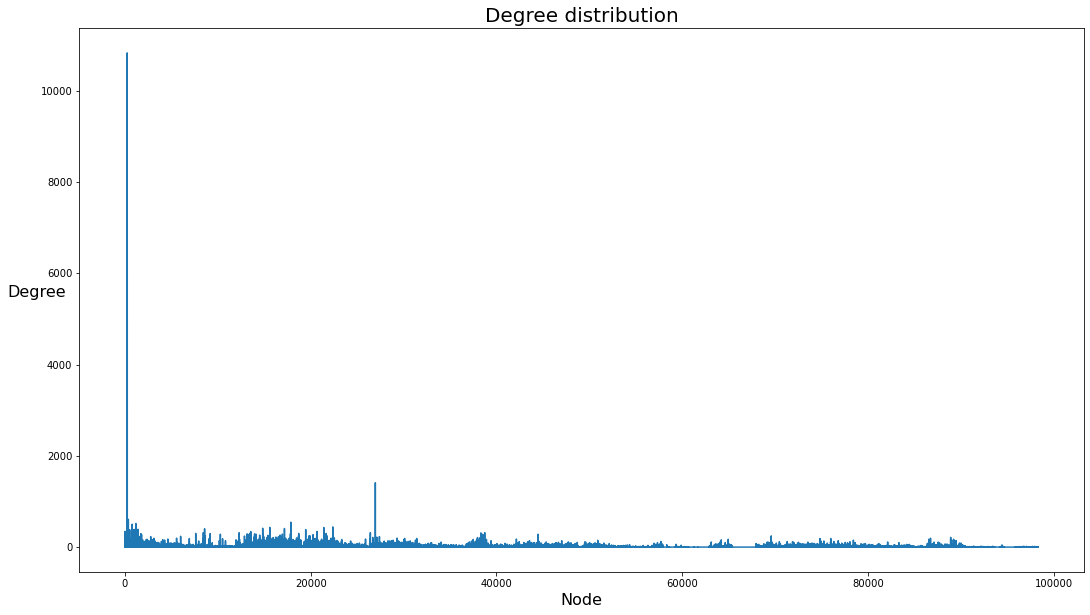

In [175]:
# degree distrubution
plt.figure(figsize=(18,10))
plt.title("Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(dict(graph.degree).values()))

## RQ2

The function __exploring__ take in input a page _v_ and a number of clcks _d_ and return a set of pages that user can reach in _d_ clicks from _v_

In [333]:
# function to explore graph
def exploring(v, d):
    p = inverted_page_names[v]
    indices = support_exploring(p, d, set())
    return { page_names[i] for i in indices }

# support function for returning values
def support_exploring(v, d, r):
    # v: page
    # d: number of clicks
    # g: input graph
    # r: return value
    if d == 0:
        return r
    for n in graph.neighbors(v):
        return support_exploring(n, d-1, r|{v})

In the next cell there is a sample of function execution, with inputs:
- page: "Marty O'Brien"
- number of clicks: 3

In [340]:
exploring('This Way (Hana Pestle album)', 3)

{'22nd Century Lifestyle', "Marty O'Brien", 'This Way (Hana Pestle album)'}

## RQ3

Support function for solving RQ3

In [ ]:
# Find the cenatral page in a category
def central_article(c):
    # c: category
    v = None
    d = 0
    degree = dict(graph.degree)
    for node in categories[c]:
        try:
            if degree[node] >= d:
                v = node
                d = degree[node]
        except:
            pass
    return v

Function to calculate distance between two nodes (pages) in network

In [317]:
# Breadth First Search
def BFS(n, g):
    # n: starting node to improve search
    # g: node goal
    frontier = Queue()
    visited = set()
    front_set = set()
    front_set.add(n)
    frontier.put(n)
    cost = 0
    while True:
        if frontier.empty():
            return "Not possible"
        node = frontier.get()
        front_set.remove(node)
        visited.add(node)
        if node == g:
            return cost
        cost += 1
        for son in graph.neighbors(node):
            if son not in visited and son not in front_set:
                frontier.put(son)
                front_set.add(son)

Function __explore_category__ returns the minimum number of clicks required to reach all pages in _p_, starting from the page _v_, corresponding to the most central article, according to the in-degree centrality, in category _c_

In [437]:
def explore_category(c, p):
    # c: category
    # p: set of pages in c
    v = central_article(c)
    pages = { inverted_page_names[name] for name in p }
    m = 0
    for page in pages:
        n = BFS(v, page) # minimum number of clicks
        if type(n) is int:
            m = max(m, n)
        else:
            return n
    return m

Test function with an input

In [486]:
c = 'Main Belt asteroids'

p = { page_names[i] for i in categories[c] }

explore_category(c, p)

'Not possible'